Usage example of MediaPipe Pose Solution API in Python (see also http://solutions.mediapipe.dev/pose).

Upload any image that that has a person. We take two example images from the web: https://unsplash.com/photos/v4zceVZ5HK8 and https://unsplash.com/photos/e_rhazQLaSs.


In [73]:
import matplotlib.pyplot as plt
def cv2_imshow(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

#@markdown To better demonstrate the Pose Landmarker API, we have created a set of visualization tools that will be used in this colab. These will draw the landmarks on a detect person, as well as the expected connections between those markers.

from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
from tqdm import tqdm

from mediapipe.python.solutions.drawing_utils import DrawingSpec
from mediapipe.python.solutions.hands import HandLandmark
from mediapipe.python.solutions.pose import PoseLandmark


# Customize visibility of landmarks
_POSE_LANDMARKS_LEFT = frozenset([
    PoseLandmark.LEFT_EYE_INNER, PoseLandmark.LEFT_EYE,
    PoseLandmark.LEFT_EYE_OUTER, PoseLandmark.LEFT_EAR, PoseLandmark.MOUTH_LEFT,
    PoseLandmark.LEFT_SHOULDER, PoseLandmark.LEFT_ELBOW,
    PoseLandmark.LEFT_WRIST, PoseLandmark.LEFT_PINKY, PoseLandmark.LEFT_INDEX,
    PoseLandmark.LEFT_THUMB, PoseLandmark.LEFT_HIP, PoseLandmark.LEFT_KNEE,
    PoseLandmark.LEFT_ANKLE, PoseLandmark.LEFT_HEEL,
    PoseLandmark.LEFT_FOOT_INDEX
])

_POSE_LANDMARKS_RIGHT = frozenset([
    PoseLandmark.RIGHT_EYE_INNER, PoseLandmark.RIGHT_EYE,
    PoseLandmark.RIGHT_EYE_OUTER, PoseLandmark.RIGHT_EAR,
    PoseLandmark.MOUTH_RIGHT, PoseLandmark.RIGHT_SHOULDER,
    PoseLandmark.RIGHT_ELBOW, PoseLandmark.RIGHT_WRIST,
    PoseLandmark.RIGHT_PINKY, PoseLandmark.RIGHT_INDEX,
    PoseLandmark.RIGHT_THUMB, PoseLandmark.RIGHT_HIP, PoseLandmark.RIGHT_KNEE,
    PoseLandmark.RIGHT_ANKLE, PoseLandmark.RIGHT_HEEL,
    PoseLandmark.RIGHT_FOOT_INDEX
])
_THICKNESS_POSE_LANDMARKS = 2
_WHITE = (224, 224, 224)


pose_landmark_style = {}
left_spec = DrawingSpec(
  color=(0, 138, 255), thickness=_THICKNESS_POSE_LANDMARKS)
right_spec = DrawingSpec(
  color=(231, 0, 0), thickness=0, circle_radius=0)
for landmark in _POSE_LANDMARKS_LEFT:
    pose_landmark_style[landmark] = left_spec
for landmark in _POSE_LANDMARKS_RIGHT:
    pose_landmark_style[landmark] = right_spec
pose_landmark_style[PoseLandmark.NOSE] = DrawingSpec(
  color=_WHITE, thickness=_THICKNESS_POSE_LANDMARKS)


def draw_landmarks_on_image(rgb_image, detection_result):
  pose_landmarks_list = detection_result.pose_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected poses to visualize.
  for idx in range(len(pose_landmarks_list)):
    pose_landmarks = pose_landmarks_list[idx]

    # Draw the pose landmarks.
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      pose_landmarks_proto,
      solutions.pose.POSE_CONNECTIONS,
      pose_landmark_style)
  return annotated_image

In [75]:
import cv2
import math
import numpy as np
from pathlib import Path
from natsort import natsorted

DESIRED_HEIGHT = 480
DESIRED_WIDTH = 480
def resize_and_show(image):
  h, w = image.shape[:2]
  if h < w:
    img = cv2.resize(image, (DESIRED_WIDTH, math.floor(h/(w/DESIRED_WIDTH))))
  else:
    img = cv2.resize(image, (math.floor(w/(h/DESIRED_HEIGHT)), DESIRED_HEIGHT))
  cv2_imshow(img)

files = natsorted(Path('data_robot/20251202-153354').glob('*_color.png'))
# images = {f.name: cv2.imread(f) for f in files}


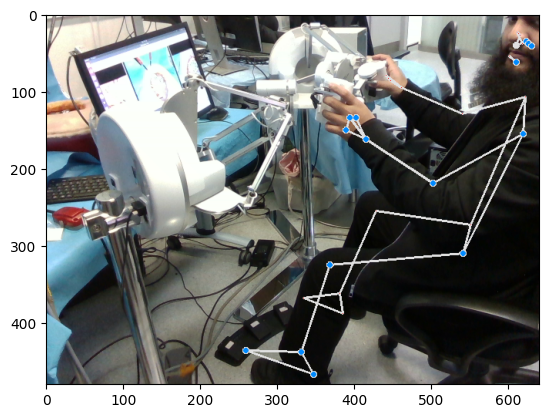

In [74]:
# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an PoseLandmarker object. Full model
with open(r'C:\Users\pcarn\Documents\Hamlyn_Project\pose_landmarker.task', 'rb') as file:
    model_data = file.read()

base_options = python.BaseOptions(model_asset_buffer=model_data)
# base_options = python.BaseOptions(model_asset_path=r'C:\Users\pcarn\Documents\Hamlyn_Project\pose_landmarker.task')
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=True,
    min_pose_detection_confidence=0.25
    )
detector = vision.PoseLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file(str(files[31]))

# STEP 4: Detect pose landmarks from the input image.
detection_result = detector.detect(image)
# detector.detect_for_video(image, 100)

# STEP 5: Process the detection result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

In [47]:
out = Path('outputs_static_landmarker')
out.mkdir(exist_ok=True)

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter(out.joinpath('output.mp4'), fourcc, 10, (640, 480))
detector = vision.PoseLandmarker.create_from_options(options)

for i,name in enumerate(tqdm(files)):
    # STEP 3: Load the input image.
    image = mp.Image.create_from_file(str(name))
    # STEP 4: Detect pose landmarks from the input image.
    detection_result = detector.detect_for_video(image, (i+1)*(1000//6))
    
    # STEP 5: Process the detection result. In this case, visualize it.
    annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
    # cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))
    cv2.imwrite(out.joinpath(name.name), cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))
    video.write(annotated_image)
video.release()

100%|████████████████████████████████████████████████████████████████████████████████| 994/994 [00:49<00:00, 20.15it/s]


In [76]:
# STEP 2: Create an PoseLandmarker object.
with open(r'C:\Users\pcarn\Documents\Hamlyn_Project\pose_landmarker_heavy.task', 'rb') as file:
    model_data = file.read()

base_options = python.BaseOptions(model_asset_buffer=model_data)
# base_options = python.BaseOptions(model_asset_path=r'C:\Users\pcarn\Documents\Hamlyn_Project\pose_landmarker.task')
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=True,
    running_mode=vision.PoseLandmarkerOptions.running_mode.VIDEO,
    min_pose_detection_confidence=0.25
    )
out = Path('outputs_video_heavy')
out.mkdir(exist_ok=True)

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter(out.joinpath('output.mp4'), fourcc, 10, (640, 480))
detector = vision.PoseLandmarker.create_from_options(options)
results = []
for i,name in enumerate(tqdm(files)):
    # STEP 3: Load the input image.
    image = mp.Image.create_from_file(str(name))
    # STEP 4: Detect pose landmarks from the input image.
    detection_result = detector.detect_for_video(image, (i+1)*(1000//6))
    
    # STEP 5: Process the detection result. In this case, visualize it.
    annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
    annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR)
    # cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))
    cv2.imwrite(out.joinpath(name.name), annotated_image)
    video.write(annotated_image)
    results.append(detection_result)
video.release()

100%|████████████████████████████████████████████████████████████████████████████████| 994/994 [01:20<00:00, 12.31it/s]


In [88]:
import pickle

results_norm_landmarks = [r.pose_landmarks for r in results]
results_seg = [r.segmentation_masks[0].numpy_view() if r.segmentation_masks else None for r in results]


with open("video_heavy_pose.pickle", "wb") as file:
    pickle.dump(results_norm_landmarks, file)

with open("video_heavy_segmentation.pickle", "wb") as file:
    pickle.dump(results_seg, file)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


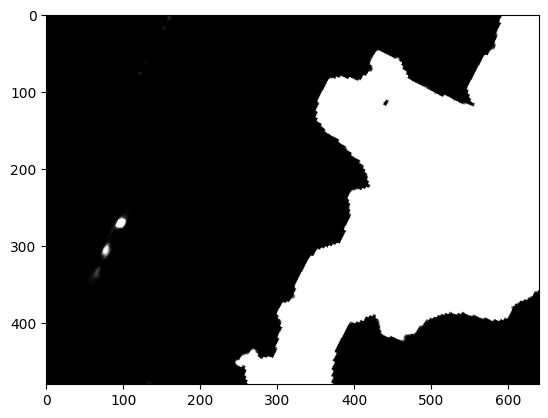

In [84]:
segmentation_mask = results[31].segmentation_masks[0].numpy_view()
visualized_mask = np.repeat(segmentation_mask[:, :, np.newaxis], 3, axis=2) * 255
cv2_imshow(visualized_mask)

In [ ]:
# Depth lifitng testing